In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
#!pip install xgboost

In [3]:
# Additional libraries for text preprocessing and feature engineering
import re
from nltk.corpus import stopwords
import numpy as np

In [4]:
# Load dataset
df = pd.read_csv("../../Fake review detection dataset/Yelp Dataset Reduced.csv")

In [5]:
df.head()

,ID,USER_ID,PRODUCT_ID,RATING,DATE,LABEL,REVIEW_TEXT,AVERAGE_RATING,RATING_DEVIATION,TOTAL_PRODUCT_REVIEWS,...,RATING_CATEGORY,SINGLE_RATING_CATEGORY,REVIEW_COUNT_DATE,SAME_DATE_MULTIPLE_REVIEWS,MAX_USER_REVIEWS_DAY,TIMESTAMP_DIFFERENCE,AVERAGE_USER_REVIEW_LENGTH,TOTAL_USER_REVIEWS,PERCENTAGE_POSITIVE_REVIEWS,RATIO_POSITIVE_NEGATIVE
0,144828,66563,416,4,10-12-2014,-1,Great.....,3.767293,0.232707,2183,...,1,1,1,0,2,0 days,11.500000,2,100.0,6.157377
1,157607,74755,449,4,26-03-2013,1,My family and I had Bubby's brunch on a Saturd...,3.396552,0.603448,812,...,1,1,2,0,2,1723 days,724.666667,12,100.0,3.121827
2,70401,49165,237,3,11-10-2011,1,"I really like this place, but they need to get...",3.799003,0.799003,602,...,1,1,2,0,1,0 days,314.000000,1,100.0,6.082353
3,124810,75653,363,5,14-01-2014,1,This is one of my favorite places in the US. A...,3.990361,1.009639,2075,...,1,1,1,0,1,0 days,280.000000,1,100.0,9.121951
4,42068,32402,100,4,02-12-2014,1,Make sure you go with a small group of friends...,3.951812,0.048188,2677,...,1,1,2,0,1,398 days,255.666667,3,100.0,8.734545


In [6]:
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Remove punctuation and special characters
    text = re.sub(r"\s+", " ", text)  # Remove extra whitespace
    stop_words = set(stopwords.words("english"))
    text = " ".join([word for word in text.split() if word not in stop_words])    
    return text

df["REVIEW_TEXT"] = df["REVIEW_TEXT"].apply(preprocess_text)

In [7]:
df.rename(columns = {'Unnamed: 0':'ID'}, inplace = True)
df['TIMESTAMP_DIFFERENCE'] = df['TIMESTAMP_DIFFERENCE'].str.replace(' days', '')
df['TIMESTAMP_DIFFERENCE'] = df['TIMESTAMP_DIFFERENCE'].astype(int)
num_features = df.drop(['ID','USER_ID','PRODUCT_ID','DATE','REVIEW_TEXT','LABEL'],axis=1)
df['LABEL'] = df['LABEL'].replace({-1: 1, 1: 0})

In [8]:
# Use TF-IDF vectorizer to convert text into numerical features
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df["REVIEW_TEXT"])
y = df["LABEL"]  

In [9]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print('X_train.shape:', X_train.shape)

print('X_test.shape', X_test.shape)

X_train.shape: (14955, 44623)
X_test.shape (4985, 44623)


In [11]:
# Oversampling with adasyn
adasyn = ADASYN(random_state=42)   #smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train )

In [12]:
# Train XGBoost classifier
model = XGBClassifier()
model.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
# from sklearn.impute import SimpleImputer

# # Create preprocessing pipelines for text and numerical features
# text_pipeline = Pipeline([
#     ('tfidf', TfidfVectorizer())  
# ])

# # Call fit_transform for text preprocessing
# text_pipeline.fit_transform(df["REVIEW_TEXT"])  # Add this line
# # ngram_range=(1, 3), max_features=5000

# num_pipeline = Pipeline([
#     ('imputer', SimpleImputer(strategy='mean')),  # Impute missing numerical data
#     ('scaler', StandardScaler())
# ])

# # Combine preprocessing for text and numerical features
# preprocessor = ColumnTransformer([
#     ('text', text_pipeline, 'REVIEW_TEXT'),
#     ('num', num_pipeline, num_features.columns.tolist())
# ])

# # Create the full pipeline with SMOTE and SVC
# pipeline = Pipeline([
#     ('preprocessor', preprocessor),
#     ('smote', SMOTE(random_state=42)),  # Oversample after preprocessing
#     ('classifier', LogisticRegression(max_iter=1000))
# ])

In [ ]:
# # Call fit_transform for text preprocessing
# print(text_pipeline.fit_transform(X_train))  # Add this line
# # ngram_range=(1, 3), max_features=5000

In [13]:
X_train.shape

(14955, 44623)

In [14]:
# Predict probabilities for test data
y_pred_proba = model.predict_proba(X_test)[:, 1]

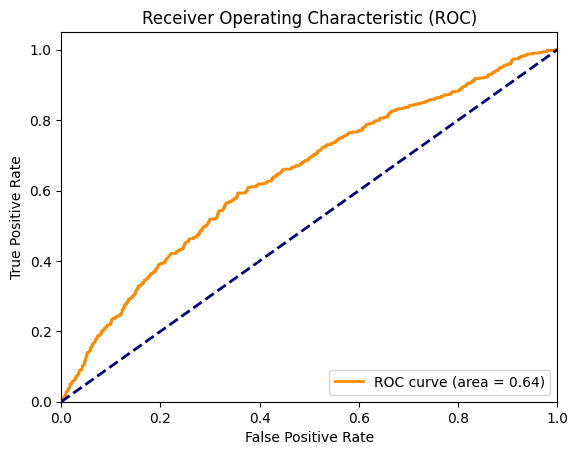

In [15]:
# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [16]:
# Make predictions on the testing data
y_pred = model.predict(X_test)

In [17]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8449348044132398
Confusion Matrix:
 [[4111  373]
 [ 400  101]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.92      0.91      4484
           1       0.21      0.20      0.21       501

    accuracy                           0.84      4985
   macro avg       0.56      0.56      0.56      4985
weighted avg       0.84      0.84      0.84      4985



In [18]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate sensitivity (true positive rate)
sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])

# Calculate specificity (true negative rate)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

# Print sensitivity and specificity
print("Sensitivity (True Positive Rate):", sensitivity)
print("Specificity (True Negative Rate):", specificity)

Sensitivity (True Positive Rate): 0.20159680638722555
Specificity (True Negative Rate): 0.9168153434433541
